In [2]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.python.framework import ops

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

import cv2

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

%matplotlib inline

Using TensorFlow backend.


In [3]:
def SqueezeExcite(tensor, ratio=16):
    nb_channel = K.int_shape(tensor)[-1]

    x = GlobalAveragePooling2D()(tensor)
    x = Dense(nb_channel // ratio, activation='relu')(x)
    x = Dense(nb_channel, activation='sigmoid')(x)

    x = Multiply()([tensor, x])
    return x

def build_model():
    K.clear_session()
    pool2_list = []
    merge_list = []

    input_size = Input(shape=(5, 200, 1))
    conv1_ = Conv2D(128, (3, 10), padding='same',activation='relu')(input_size)
    conv1  = SqueezeExcite(conv1_)
    conv2_ = Conv2D(64, (3, 1), padding='same',activation='relu')(conv1)
    conv2  = SqueezeExcite(conv2_)
    conv3_ = Conv2D(64, (3, 3), padding='same',activation='relu')(conv2)
    conv3  = SqueezeExcite(conv3_)
    conv4_ = Conv2D(128, (3, 1), padding='same',activation='relu')(conv3)
    conv4  = SqueezeExcite(conv4_)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5_ = Conv2D(64, (3, 3), padding='same',activation='relu')(pool1)
    conv5  = SqueezeExcite(conv5_)
    conv6_ = Conv2D(64, (3, 3), padding='same',activation='relu')(conv5)
    conv6  = SqueezeExcite(conv6_)
    conv7_ = Conv2D(128, (3, 1), padding='same',activation='relu')(conv6)
    conv7  = SqueezeExcite(conv7_)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv7)

    x = Flatten()(pool2)
    dense1_ = Dense(256, activation='relu')
    dense1  = dense1_(x)
    x = Dropout(0.4)(dense1)
    dense2  = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(dense2)
    dense3 = Dense(32, activation='relu')(x)
    pred_output = Dense(1, activation='sigmoid')(dense3)
    model = Model(input=[input_size], output=[pred_output])
    model.summary()

    return model

In [4]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-w', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-x', '--in_dir', type=str, help='input_directory')
parser.add_argument('-y', '--cell_name', type=str, help='name of the cell')
parser.add_argument('-z', '--out_dir', type=str, help='output_directory')
parser.add_argument('-a', '--track1_peaks', type=str, help='chromatin accessibility peak')
parser.add_argument('-b', '--track2_peaks', type=str, help='ChIP-seq H3K27ac peak')
parser.add_argument('-c', '--track3_peaks', type=str, help='ChIP-seq H3K4me3 peak')
parser.add_argument('-d', '--track4_peaks', type=str, help='ChIP-seq H3K9ac peak')
parser.add_argument('-e', '--track5_peaks', type=str, help='ChIP-seq H3K4me1 peak')
parser.add_argument('-f', '--track1_bw', type=str, help='chromatin accessibility bigWig')
parser.add_argument('-g', '--track2_bw', type=str, help='ChIP-seq H3K27ac bigWig')
parser.add_argument('-i', '--track3_bw', type=str, help='ChIP-seq H3K4me3 bigWig')
parser.add_argument('-j', '--track4_bw', type=str, help='ChIP-seq H3K9ac bigWig')
parser.add_argument('-k', '--track5_bw', type=str, help='ChIP-seq H3K4me1 bigWig')

cell_type = "HepG2"

#simulate command line input
seqdir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/" + cell_type + "/"
cmdline_str='-w ' + " HepG2,K562,A549,HCT116,MCF-7 " + \
    ' -x ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/pipeline/encoded/DNase/" + \
    ' -y ' + "HepG2" + \
    ' -z ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/pipeline/output/" + \
    ' -a ' + seqdir+cell_type+".DNase-seq.narrowPeak" + \
    ' -b ' + seqdir+cell_type+".ChIP-seq.H3K27ac.narrowPeak" + \
    ' -c ' + seqdir+cell_type+".ChIP-seq.H3K4me3.narrowPeak" + \
    ' -d ' + seqdir+cell_type+".ChIP-seq.H3K9ac.narrowPeak" + \
    ' -e ' + seqdir+cell_type+".ChIP-seq.H3K4me1.narrowPeak" + \
    ' -f ' + seqdir+cell_type+".DNase-seq.bigWig" + \
    ' -g ' + seqdir+cell_type+".ChIP-seq.H3K27ac.bigWig" + \
    ' -i ' + seqdir+cell_type+".ChIP-seq.H3K4me3.bigWig" + \
    ' -j ' + seqdir+cell_type+".ChIP-seq.H3K9ac.bigWig" + \
    ' -k ' + seqdir+cell_type+".ChIP-seq.H3K4me1.bigWig"

seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
            
for key, value in vars(args).items():
    if key == "cell_types" or key == "in_dir" or key == "out_dir" or key == "cell_name":
        continue
    else:
        if not os.path.exists(value):
            print(key + " argument file does not exist")
            exit(1)
print("all files found!")

#construct a set of autosome + X chromosome names
chromosomes = []
for i in range(1,23):
    chromosomes.append("chr"+str(i))
chromosomes.append("chrX")
print(chromosomes)
print("all files found!")

all files found!
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
all files found!


In [5]:
def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred, curve="ROC", summation_method='careful_interpolation')[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def auprc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred, curve='PR', summation_method='careful_interpolation')[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
def get_data(cell_types, in_dir, seq_names):

    first_cell = True
    for cell in cell_types:
        print(cell)

        pos = []
        neg = []
        first_seq = True
        for seq in seq_names:
            print("-"+seq)

            pos_name = in_dir+cell+"."+seq+".pos.tsv"
            pos_mat = np.loadtxt(pos_name, delimiter='\t')

            neg_name = in_dir+cell+"."+seq+".neg.tsv"
            neg_mat = np.loadtxt(neg_name, delimiter='\t')

            if first_seq:
                for i in pos_mat:
                    pos.append(np.array([i]))
                for i in neg_mat:
                    neg.append(np.array([i]))
                first_seq = False
            else:
                for i in range(len(pos)):
                    pos[i] = np.vstack((pos[i], pos_mat[i,]))
                for i in range(len(neg)):
                    neg[i] = np.vstack((neg[i], neg_mat[i,]))

        if first_cell == True:
            X_pos = np.array(pos)
            X_neg = np.array(neg)
            first_cell = False
        else:
            X_pos = np.vstack((X_pos, pos))
            X_neg = np.vstack((X_neg, neg))

    X = np.vstack((X_pos, X_neg))
    y = np.array([1 for i in range(X_pos.shape[0])] + [0 for i in range(X_pos.shape[0])]).reshape(-1,1)
    
    return X, y

In [7]:
#render enhancers as pixels
    #extract signals
    #matplotlib
seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]
X, y = get_data([cell_type], "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/pipeline/encoded/DNase/", seq_names)

HepG2
-DNase
-H3K27ac
-H3K4me3
-H3K9ac
-H3K4me1


In [8]:
print(X.shape)
print(y.shape)

(26222, 5, 200)
(26222, 1)


In [9]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [10]:
# def build_guided_model():
#     """Function returning modified model.
    
#     Changes gradient function for all ReLu activations
#     according to Guided Backpropagation.
#     """
#     if "GuidedBackProp" not in ops._gradient_registry._registry:
#         @ops.RegisterGradient("GuidedBackProp")
#         def _GuidedBackProp(op, grad):
#             dtype = op.inputs[0].dtype
#             return grad * tf.cast(grad > 0., dtype) * \
#                    tf.cast(op.inputs[0] > 0., dtype)

#     g = tf.get_default_graph()
#     with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
#         new_model = build_model()
#     return new_model

model = build_model()
#guided_model = build_guided_model()
model = load_model('hg38_evaluation.h5', custom_objects={"auroc": auroc, 
                                                         "auprc": auroc, 
                                                         "f1_m": f1_m, 
                                                         "recall_m": recall_m,
                                                         "precision_m": precision_m})

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 200, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 200, 128)  3968        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

In [11]:
def cam_pred_1d(model, x_validation):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([x_validation])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (200, 1), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
    return cam

def cam_pred_5d(model, x_validation):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([x_validation])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (200, 5), cv2.INTER_LINEAR)
#     print(cam.shape)
    cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
    return cam

In [12]:
x_validation = np.expand_dims(np.array(X), axis=4)

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


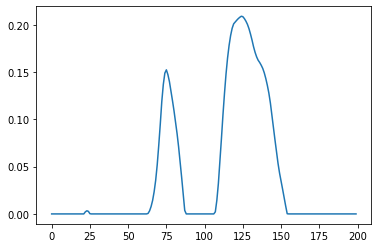

In [28]:
plt.plot(cam_pred_1d(model, np.expand_dims(x_validation[100], axis=0))[0]);

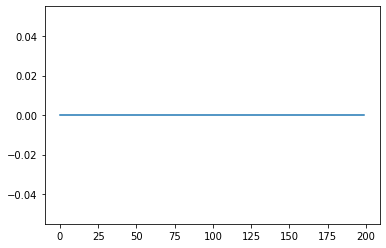

In [24]:
plt.plot(cam_pred_1d(model, np.expand_dims(x_validation[-100], axis=0))[0]);

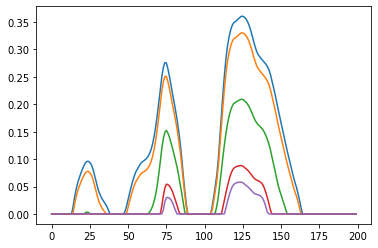

In [25]:
cam_5d = cam_pred_5d(model, np.expand_dims(x_validation[100], axis=0))
for i in range(cam_5d.shape[0]):
    plt.plot(cam_5d[i,])
plt.show()

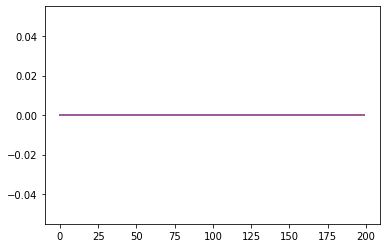

In [26]:
cam_5d = cam_pred_5d(model, np.expand_dims(x_validation[-100], axis=0))
for i in range(cam_5d.shape[0]):
    plt.plot(cam_5d[i,])
plt.show()

In [16]:
def cam_pred_multi_1d(model, X):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([X])
    weights = np.mean(grads_val, axis=(1, 2))

    all_cam = []
    for i in range(len(weights)):
        cam = np.dot(output[i], weights[i])
        cam = cv2.resize(cam, (200, 1), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        all_cam.append(cam[0])

    all_cam = np.array(all_cam)
    return all_cam

def cam_pred_multi_5d(model, X):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_7"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([X])
    weights = np.mean(grads_val, axis=(1, 2))

    all_cam = []
    for i in range(len(weights)):
        cam = np.dot(output[i], weights[i])
        cam = cv2.resize(cam, (200, 5), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        all_cam.append(cam[0])

    all_cam = np.array(all_cam)
    return all_cam


In [22]:
pos_len = len(y[y==1])
print(x_validation.shape)
# pos_cam = cam_pred_multi_1d(model, x_validation[0:1000])
# neg_cam = cam_pred_multi_1d(model, x_validation[pos_len:pos_len+1000])
# print(pos_cam.shape)
# print(neg_cam.shape)

(26222, 5, 200, 1)


In [18]:
pos_cam = []
neg_cam = []
for i in range(int(pos_len/1000) + 1):
    if (i % 10 == 0):
        print(i, ",000")
    if ((i+1)*1000 > pos_len):
        end_idx = pos_len
    else:
        end_idx = (i+1)*1000
    pos_idx = slice(i*1000, end_idx)
    neg_idx = slice(pos_len + i*1000, pos_len + end_idx)
    pos_cam.extend(cam_pred_multi_1d(model, x_validation[pos_idx]))
    neg_cam.extend(cam_pred_multi_1d(model, x_validation[neg_idx]))
pos_cam = np.array(pos_cam)
neg_cam = np.array(neg_cam)

0 ,000
10 ,000


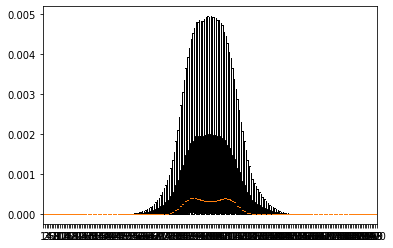

In [19]:
plt.boxplot(pos_cam, showfliers=False);

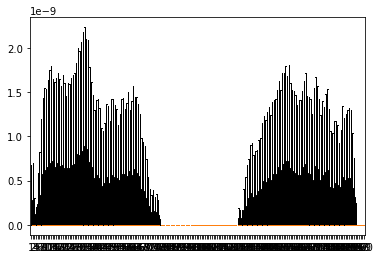

In [20]:
plt.boxplot(neg_cam, showfliers=False);